In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from load_data import load_gzip_txt_data

european_countries = [
    "Albania", "Andorra", "Armenia", "Austria", "Azerbaijan", "Belarus",
    "Belgium", "Bosnia and Herzegovina", "Bulgaria", "Croatia", "Cyprus",
    "Czech Republic", "Denmark", "England", "Estonia", "Finland", "France", "Georgia",
    "Germany", "Gibraltar", "Greece", "Hungary", "Iceland", "Ireland", "Italy", "Jersey", "Kazakhstan",
    "Kosovo", "Latvia", "Liechtenstein", "Lithuania", "Luxembourg", "Malta",
    "Moldova", "Monaco", "Montenegro", "Netherlands", "Northern Ireland", "Macedonia",
    "Norway", "Poland", "Portugal", "Romania", "Russia", "San Marino", "Scotland", "Serbia",
    "Slovakia", "Slovak Republic", "Slovenia", "Spain", "Sweden", "Switzerland", "Turkey",
    "Ukraine", "Vatican City", "Wales"
]

# /!\ Slovakia in RateBeer and Slovak Republic in BeerAdvocate /!\

def get_na_or_eu(row):
    """
    In a Dataframe with a column "location", returns whether the location 
    is in Europe or North America.
    
    :param row: pandas.Dataframe row with an attribute "location".
    :return: str, can be "NA", "EU" or "Other".
    """
    location = row['location']
    if location in european_countries:
        return 'EU'
    elif (location == 'Canada') or ("United States" in str(location)):
        return 'NA'
    else:
        return 'Other'


ba_users_df = pd.read_csv("./data/BeerAdvocate/users.csv")[['user_id', 'location']].dropna()
ba_users_df['eu_na'] = ba_users_df.apply(get_na_or_eu, axis=1)

rb_users_df = pd.read_csv("./data/RateBeer/users.csv")[['user_id', 'location']].dropna()
rb_users_df['eu_na'] = rb_users_df.apply(get_na_or_eu, axis=1)

ba_users_df = ba_users_df.query("eu_na != 'Other'")
rb_users_df = rb_users_df.query("eu_na != 'Other'")

ba_ratings_df = load_gzip_txt_data("./data/BeerAdvocate/ratings.txt.gz",
                                   ["user_id", "date", "abv", "style", "rating", "appearance", "aroma", "palate",
                                    "taste", "overall"])
rb_ratings_df = load_gzip_txt_data("./data/RateBeer/ratings.txt.gz",
                                   ["user_id", "date", "abv", "style", "rating", "appearance", "aroma", "palate",
                                    "taste", "overall"])


Loading data from:  ./data/BeerAdvocate/ratings.txt.gz


151074576it [07:37, 330144.86it/s]


Loading data from:  ./data/RateBeer/ratings.txt.gz


121075258it [06:20, 317807.20it/s]


In [5]:
ba_ratings_df = ba_ratings_df.astype({
    'user_id': 'str',
    'date': 'int64',
    'abv': 'float32',
    'rating': 'float32',
    'appearance': 'float32',
    'aroma': 'float32',
    'palate': 'float32',
    'taste': 'float32',
    'overall': 'float32'})

rb_ratings_df = rb_ratings_df.astype({
    'user_id': 'int64',
    'date': 'int64',
    'abv': 'float32',
    'rating': 'float32',
    'appearance': 'float32',
    'aroma': 'float32',
    'palate': 'float32',
    'taste': 'float32',
    'overall': 'float32'})

# Convert the dates to monthly periods (useful for plotting):
ba_ratings_df['date'] = pd.to_datetime(ba_ratings_df['date'], unit='s').dt.to_period('m').astype('datetime64[M]')
rb_ratings_df['date'] = pd.to_datetime(rb_ratings_df['date'], unit='s').dt.to_period('m').astype('datetime64[M]')

beer_styles_matching = pd.read_csv("./data/additional/styles_matching.csv", index_col='specific')['general'].to_dict()

def specific_style_to_general(row):
    return beer_styles_matching[row['style']]

ba_ratings_df['style'] = ba_ratings_df.apply(specific_style_to_general, axis=1)
rb_ratings_df['style'] = rb_ratings_df.apply(specific_style_to_general, axis=1)

# Drop Saké
ba_ratings_df = ba_ratings_df.query("style != 'Saké'")
rb_ratings_df = rb_ratings_df.query("style != 'Saké'")

ba_df = ba_ratings_df.merge(ba_users_df, on='user_id').drop(columns=['user_id'])
rb_df = rb_ratings_df.merge(rb_users_df, on='user_id').drop(columns=['user_id'])

del ba_ratings_df
del ba_users_df
del rb_ratings_df
del rb_users_df

ba_style_abv_df = pd.read_csv("./data/BeerAdvocate/beers.csv")[['style', 'abv']].dropna()
rb_style_abv_df = pd.read_csv("./data/RateBeer/beers.csv")[['style', 'abv']].dropna()

ba_style_abv_df = pd.read_csv("./data/BeerAdvocate/beers.csv")[['style', 'abv']].dropna()
rb_style_abv_df = pd.read_csv("./data/RateBeer/beers.csv")[['style', 'abv']].dropna()

ba_style_abv_df['style'] = ba_style_abv_df.apply(specific_style_to_general, axis=1)
rb_style_abv_df['style'] = rb_style_abv_df.apply(specific_style_to_general, axis=1)

# Drop Saké
ba_style_abv_df = ba_style_abv_df.query("style != 'Saké'")
rb_style_abv_df = rb_style_abv_df.query("style != 'Saké'")

sns.set_theme()
hue_order = ['NA', 'EU']
hue_order_styles = rb_df["style"].unique()

In [6]:
# merging ba and rb for time series, since we only need to consider abv

merge_list = ['date', 'style', 'abv', 'appearance', 'palate', 'eu_na']
df_time = pd.concat([rb_df[merge_list], ba_df[merge_list]], ignore_index=True).dropna(subset=['abv'])

df_EU = df_time[df_time['eu_na'] == 'EU']
df_NA = df_time[df_time['eu_na'] == 'NA']

# define a function that groups by the month

def abv_by_month(df):
    """
    Groups the dataframe by month and returns a new dataframe with the average abv for each month with date as index
    We only take time after 2000
    :param df: pandas.Dataframe with a column "date" and a column "abv".
    :return: pandas.Dataframe with a column "date" and a column "abv".
    """
    df = df[(df['date'] > '2003-01-01') & (df['date'] < '2017-01-01')] # NOTE: CONSIDER SPECIFYING DATE RANGE
    df_new = df[['date','abv']].dropna(subset=['abv']).groupby(pd.Grouper(key='date', freq='M')).mean().sort_values(by='date') 
    df_new.index = df_new.index.strftime('%Y-%m')
    df_new.index = pd.to_datetime(df_new.index)
    return df_new


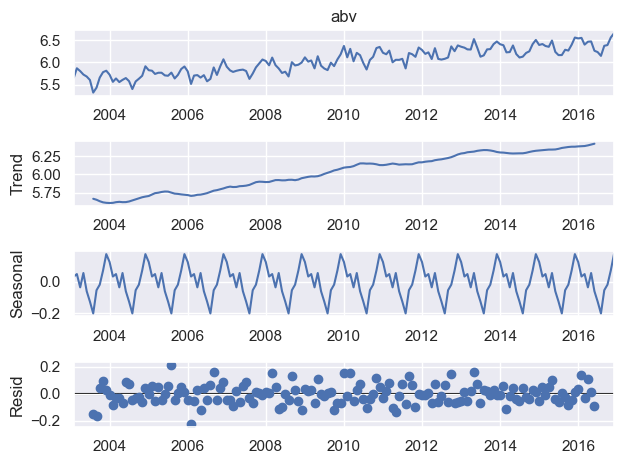

In [7]:
# use time series analysis from stsmodels to find the trend and seasonality
import statsmodels.api as sm

EU_tot = abv_by_month(df_EU)
NA_tot = abv_by_month(df_NA)

res_EU = sm.tsa.seasonal_decompose(EU_tot['abv'])
res_NA = sm.tsa.seasonal_decompose(NA_tot['abv'])

resplot_EU = res_EU.plot()


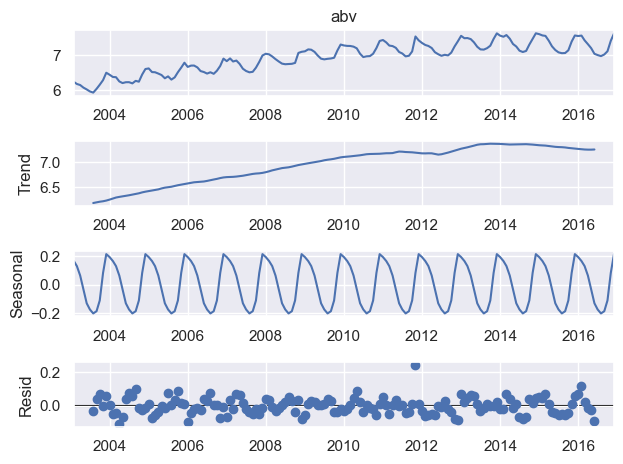

In [8]:
resplot_NA = res_NA.plot()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


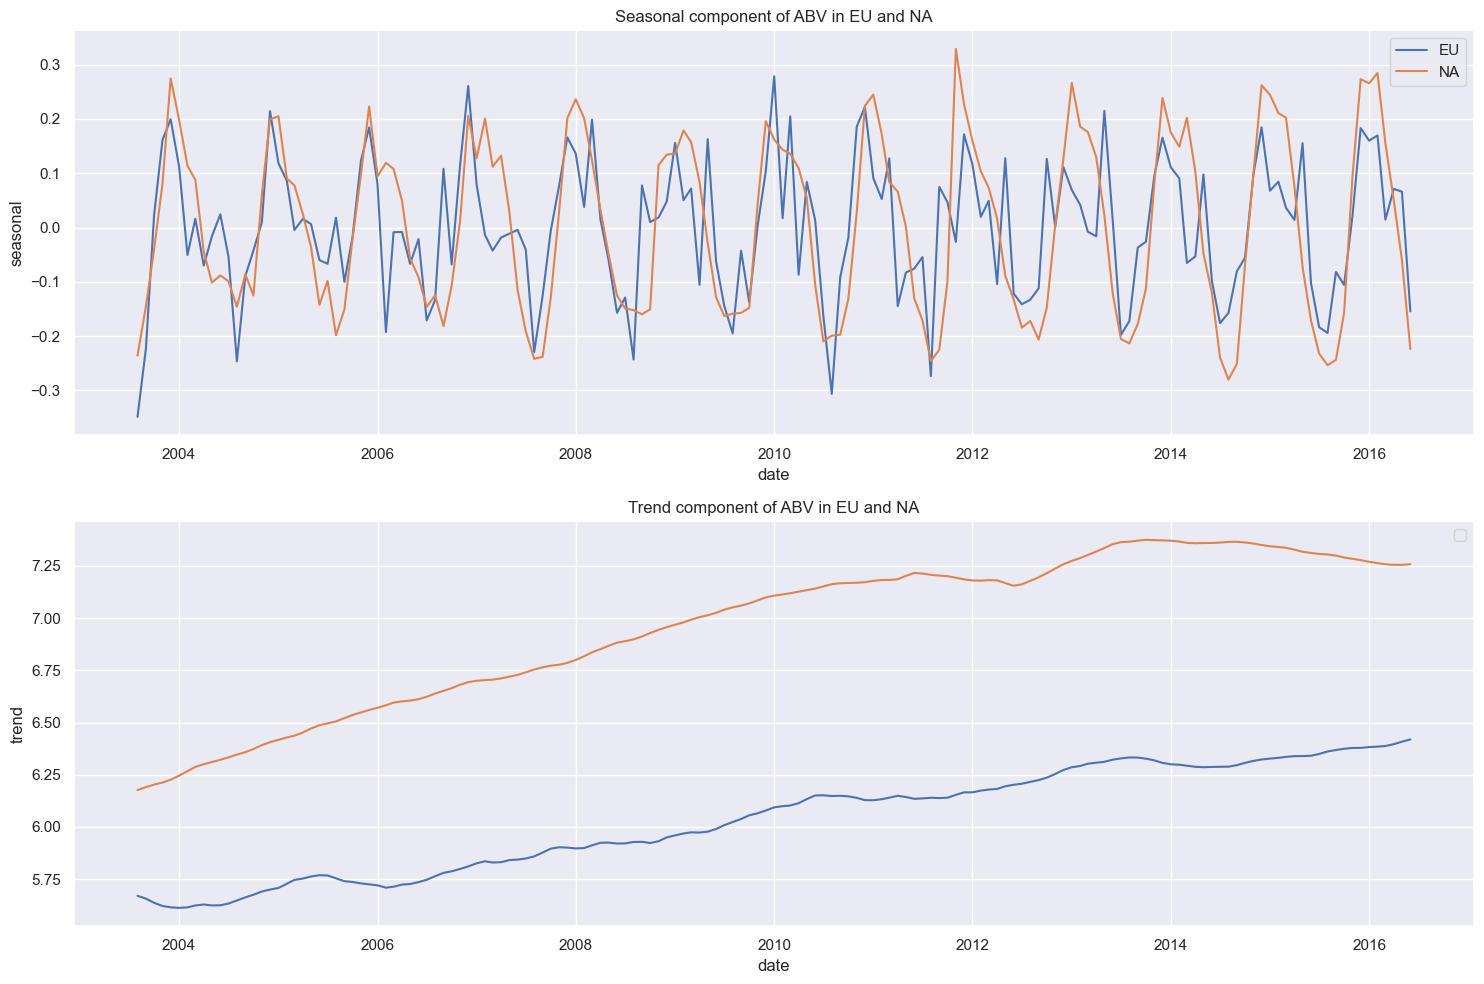

In [9]:
# obtain seasonal component for NA and EU and plot them together as well as trend add all non-trend components for seasonality

# convert res to dataframe

def res_to_df(res):
    """
    Converts the result of seasonal_decompose to a pandas.Dataframe.
    
    :param res: result of seasonal_decompose.
    :return: pandas.Dataframe with columns "observed", "trend", "seasonal", "resid".
    """
    res_df = pd.DataFrame(res.observed)
    res_df['trend'] = res.trend
    res_df['seasonal'] = res.observed - res.trend
    res_df.reset_index(inplace=True)
    return res_df.dropna()

EU_time = res_to_df(res_EU)
NA_time = res_to_df(res_NA)

fig, axes = plt.subplots(2,1, figsize=(15,10))
sns.lineplot(data=EU_time, x='date', y='seasonal', ax=axes[0], label='EU')
sns.lineplot(data=NA_time, x='date', y='seasonal', ax=axes[0], label='NA')
sns.lineplot(data=EU_time, x='date', y='trend', ax=axes[1])
sns.lineplot(data=NA_time, x='date', y='trend', ax=axes[1])
axes[0].set(title='Seasonal component of ABV in EU and NA')
axes[1].set(title='Trend component of ABV in EU and NA')

plt.legend()
plt.tight_layout()
plt.show()

## Observation
- There seems to be a second smaller peak in EU in Fall, which is not visible in America

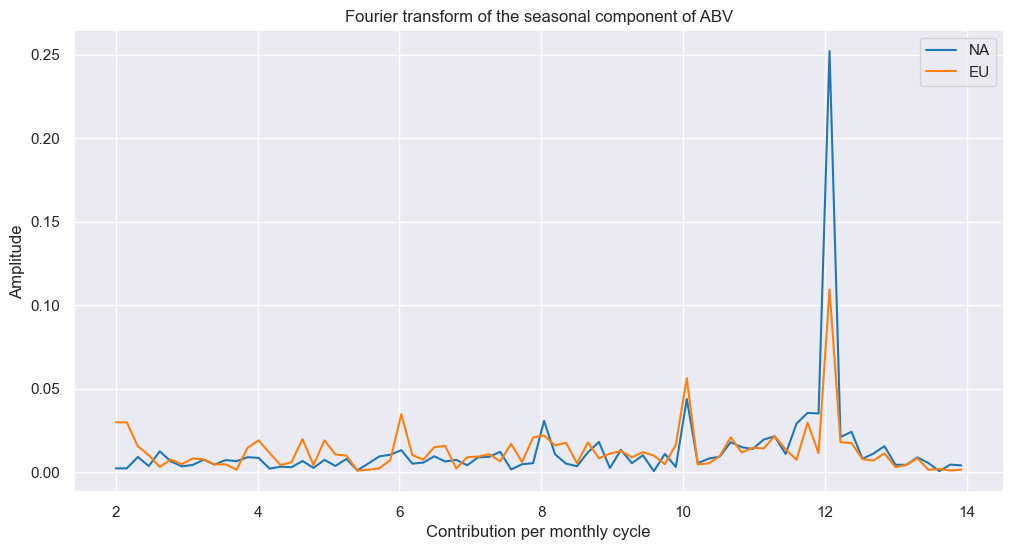

In [10]:
# perform a fourier transform on the seasonal component to find the dominant frequencies
import numpy as np
from scipy.fft import fft, fftfreq, fftshift


def fourier_transform(list_df, names_list):
    """
    Performs a fourier transform on the seasonal component of the dataframe and plots it on a list of df's
    :param list_df: list of pandas.Dataframe with a column "seasonal".
    :param names_list: list of names for the legend
    plot normalised fourier transform of the seasonal component with monthly contributions
    :return: dict with all created ffts
    """
    if len(list_df) > 2:
        palette = sns.color_palette("tab20")
    else:
        palette = sns.color_palette("tab10")
    fft_dict = {}
    fig, ax = plt.subplots(figsize=(12,6))
    for val, df in enumerate(list_df):
        series = df['seasonal']
        N = len(series)
        T = 1 / 12
        yf = np.abs(fft(series.to_numpy()))
        xf = fftfreq(N, T) # get and transform frequencies to periods of months
        xf = fftshift(xf) # shift 0 to center of axis
        index = np.where(xf >= 0) # only take positive frequencies
        # convert to monthly contributions, shift by 1 (0 -> 1 because 0 frequency has no meaning here) 
        # and multiply by 2 to account for the negative frequencies
        xf =  (xf[index] + 1) * 2 
        yf =  yf[index]
        yf = yf / sum(yf) # normalise w.r.t. the peak to weaken those with lot of noise throughout the year -> highlight those that mainly peak once per year
        fft_df = pd.DataFrame({'fft': yf, 'time': xf}) # add FT and time as df to dict
        fft_dict[f"df_{names_list[val]}"] = fft_df

        sns.lineplot(data=fft_df, x='time', y='fft', label=names_list[val], color=palette[val], ax=ax)
    ax.set(xlabel='Contribution per monthly cycle', 
            ylabel='Amplitude',
            title='Fourier transform of the seasonal component of ABV')
    if len(list_df) > 2:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    return fft_dict

    


# test function

fft_dict = fourier_transform([NA_time, EU_time],['NA', 'EU'])


## Observations
- Main contribution clearly comes from yearly seasonality
- Some shaping coefficients are seen at very 2month interval, as they can be seen in the purely seasonal data as well
- The other contributions are basically noise (residual contribution)

In [11]:
# create abv by month for every style
styles_list = df_EU['style'].unique()
hue_order_styles = styles_list
palette = sns.color_palette("tab20")
df_dict_EU = {} # store all dfs in a dictionary to access them later for the FFT 
df_dict_NA = {}
names_list = []


# repeat the whole process until FT for every style
phase_EU = []
phase_NA = []
for style in styles_list:
    # Create your DataFrame (replace this with your actual code to create the DataFrame)
    df1 = df_EU[df_EU['style'] == style]
    df2 = df_NA[df_NA['style'] == style]
    # month averaging
    df1_tot = abv_by_month(df1)
    df2_tot = abv_by_month(df2)
    # seasonal decomposition
    df1_tot = df1_tot.fillna(method='ffill') # fill missing values with previous month to avoid error
    df2_tot = df2_tot.fillna(method='ffill')
    res_df1 = sm.tsa.seasonal_decompose(df1_tot['abv'])
    res_df2 = sm.tsa.seasonal_decompose(df2_tot['abv'])
    # extract phase
    indx_1 = res_df1.seasonal.idxmax()
    phase_EU.append(indx_1.strftime('%B'))
    indx_2 = res_df2.seasonal.idxmax()
    phase_NA.append(indx_2.strftime('%B'))
    
    # convert red to df
    df1_time = res_to_df(res_df1)
    df2_time = res_to_df(res_df2)

    # Store DataFrames in the dictionary
    df_dict_EU[f"df_EU_{style}"] = df1_time
    df_dict_NA[f"df_NA_{style}"] = df2_time

    names_list.append(style)
# extract the dfs from the dictionary and put them in a list
df_list_EU = [df_dict_EU[f"df_EU_{style}"] for style in styles_list]
df_list_NA = [df_dict_NA[f"df_NA_{style}"] for style in styles_list]


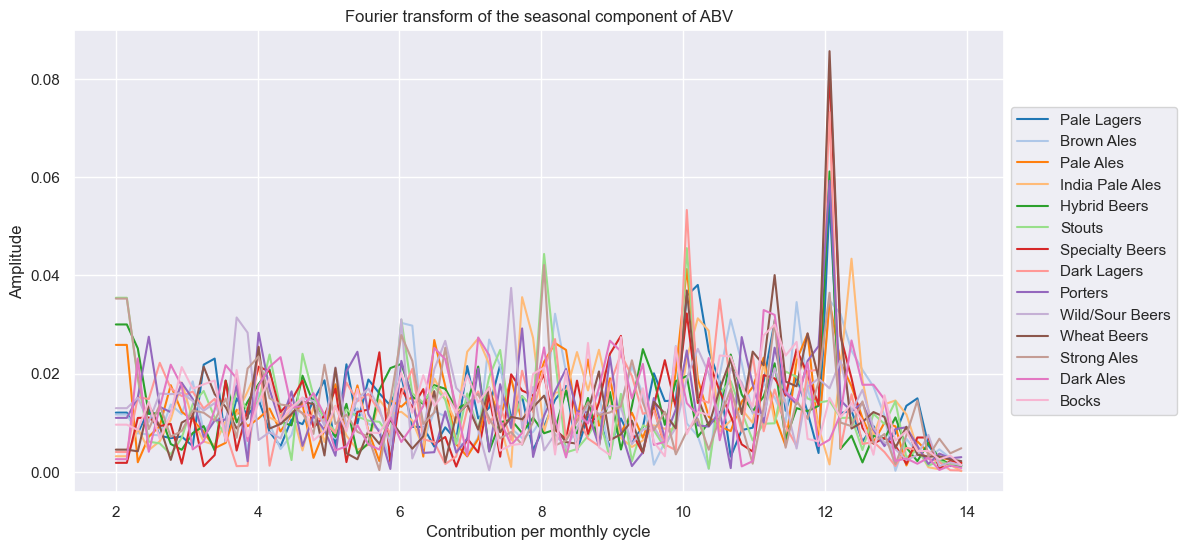

In [12]:
# Now we can finally plot the fourier transform for every style for EU and NA

fft_dict_EU = fourier_transform(df_list_EU, names_list)

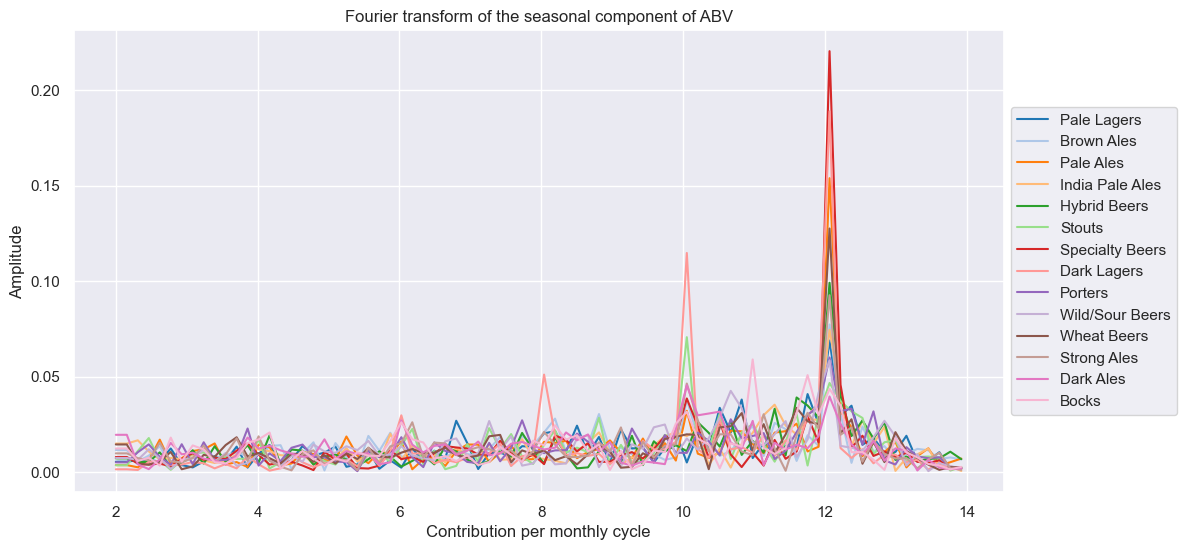

In [13]:
fft_dict_NA = fourier_transform(df_list_NA, names_list)

In [14]:
# filter dicts for styles with max fft value > 0.1

def filter_dict(fft_dict, threshold):
    """
    Filters the dictionary of ffts for styles with a maximum fft around the 12-month cycle value above a threshold.
    
    :param fft_dict: dict with ffts.
    :param threshold: float, minimum threshold for the maximum fft value.
    :return: dict with ffts and list of index of the styles with a maximum fft above the threshold to track phase and color for each style
    """
    filtered_dict = {}
    index = [] # index for colors and phases
    keys_list = list(fft_dict.keys())
    for key, df in fft_dict.items():
        if df[(df['time'] > 11.7) & (df['time'] < 12.3)]['fft'].max() > threshold:
            filtered_dict[key] = df
            index.append(keys_list.index(key))

    return filtered_dict, index

# NOTE: The threshold values were chosen by looking at the plots and finding the lowest max such that the peaks of all styles considered are around the 12 month cycle
fft_dict_EU_filtered, colors_EU = filter_dict(fft_dict_EU, 0.04)
fft_dict_NA_filtered, colors_NA = filter_dict(fft_dict_NA, 0.052)

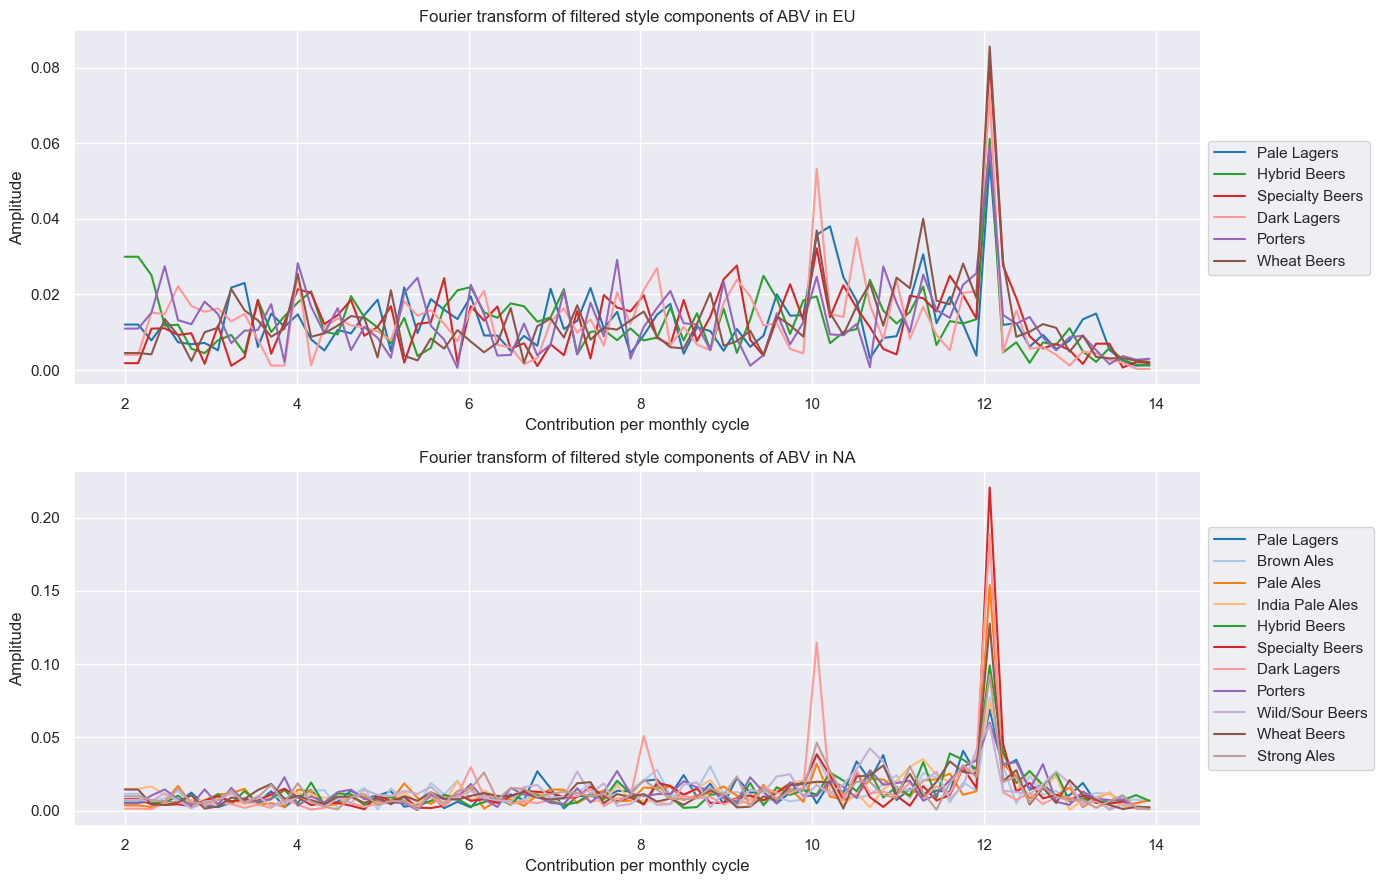

In [15]:
# plot the filtered dicts

fig, axes = plt.subplots(2,1, figsize=(14,9))
for val, (key, df) in enumerate(fft_dict_EU_filtered.items()):
    sns.lineplot(data=df, x='time', y='fft', label=key[3:], ax=axes[0], color=palette[colors_EU[val]])
axes[0].set(xlabel='Contribution per monthly cycle', 
            ylabel='Amplitude',
            title='Fourier transform of filtered style components of ABV in EU')
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
for val, (key, df) in enumerate(fft_dict_NA_filtered.items()):
    sns.lineplot(data=df, x='time', y='fft', label=key[3:], ax=axes[1], color=palette[colors_NA[val]])
axes[1].set(xlabel='Contribution per monthly cycle', 
            ylabel='Amplitude',
            title='Fourier transform of filtered style components of ABV in NA')
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


In [16]:
# create a new dataframe that contains fft_dict['EU'] 'fft' and 'time' as well as all df's stored in df_dict_EU

fft_df_EU = fft_dict['df_EU']
fft_df_EU = fft_df_EU[['time', 'fft']]
fft_df_EU = fft_df_EU.rename(columns={'fft': 'fft_tot'})


# note that we merge closest on time, additionaly save the phase min and max as separate arrays
for key, df in fft_dict_EU_filtered.items():
        fft_df_EU = pd.merge_asof(fft_df_EU, fft_dict_EU[key][['time','fft']], on='time')
        fft_df_EU = fft_df_EU.rename(columns={'fft': f'{key[3:]}'})

# do the same for NA

fft_df_NA = fft_dict['df_NA']
fft_df_NA = fft_df_NA[['time', 'fft']]
fft_df_NA = fft_df_NA.rename(columns={'fft': 'fft_tot'})

# note that we merge closest on time
for key, df in fft_dict_NA_filtered.items():
        fft_df_NA = pd.merge_asof(fft_df_NA, fft_dict_NA[key][['time','fft']], on='time')
        fft_df_NA = fft_df_NA.rename(columns={'fft': f'{key[3:]}'})

# only keep values betweeen 11.5 and 12.5

fft_df_NA

,time,fft_tot,Pale Lagers,Brown Ales,Pale Ales,India Pale Ales,Hybrid Beers,Specialty Beers,Dark Lagers,Porters,Wild/Sour Beers,Wheat Beers,Strong Ales
0,2.000000,0.002298,0.005338,0.011440,0.003549,0.014840,0.007097,0.007804,0.001354,0.005004,0.007296,0.014378,0.009712
1,2.154839,0.002298,0.005338,0.011440,0.003549,0.014840,0.007097,0.007804,0.001354,0.005004,0.007296,0.014378,0.009712
2,2.309677,0.009076,0.006184,0.005474,0.002413,0.016550,0.005114,0.004341,0.000998,0.010300,0.006281,0.004262,0.007224
3,2.464516,0.003689,0.006321,0.008512,0.006057,0.010725,0.005269,0.003843,0.005305,0.014430,0.011852,0.003816,0.005992
4,2.619355,0.012491,0.005405,0.013449,0.016895,0.006503,0.010244,0.004306,0.005762,0.007835,0.007013,0.005575,0.015292
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,13.303226,0.008862,0.005511,0.012065,0.008276,0.009199,0.005531,0.005289,0.006355,0.008067,0.009266,0.007302,0.001838
74,13.458065,0.005499,0.005995,0.011326,0.012350,0.012205,0.006825,0.004701,0.001145,0.007173,0.000401,0.003818,0.006566
75,13.612903,0.000659,0.010293,0.006714,0.003337,0.002707,0.007099,0.006045,0.004786,0.007685,0.004587,0.001058,0.010057
76,13.767742,0.004561,0.001454,0.007570,0.005074,0.003104,0.010577,0.001771,0.001533,0.002578,0.003026,0.002495,0.001932


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


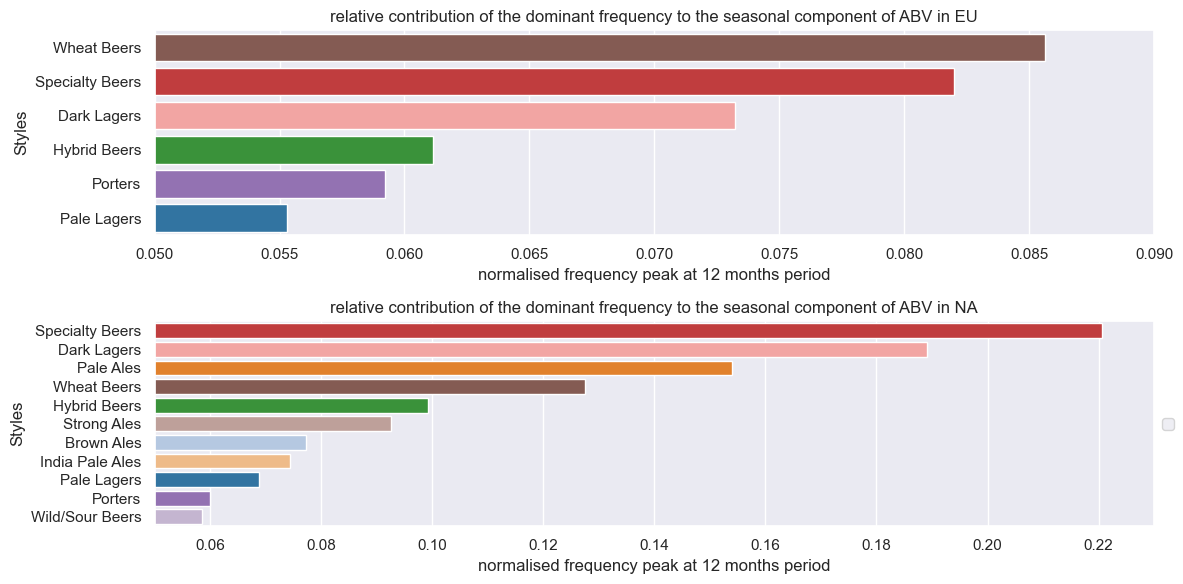

In [17]:
# take max and index of the max of each column and plot them as scatter
fft_df_EU = fft_df_EU[(fft_df_EU['time'] > 11.7) & (fft_df_EU['time'] < 12.3)]
fft_df_NA = fft_df_NA[(fft_df_NA['time'] > 11.7) & (fft_df_NA['time'] < 12.3)]

max_df_EU = pd.DataFrame({'max': fft_df_EU.iloc[:, 2:].max(), 'index': fft_df_EU.iloc[:, 2:].idxmax()})
max_df_NA = pd.DataFrame({'max': fft_df_NA.iloc[:, 2:].max(), 'index': fft_df_NA.iloc[:, 2:].idxmax()})

# maintain same colors for each style by saving color as column
cols_EU = [palette[x] for x in colors_EU]
max_df_EU['color'] = cols_EU # to maintain same colors for each style
phases_EU = [phase_EU[x] for x in colors_EU]
max_df_EU['phase'] = phases_EU # colors_EU contains index of corresponding style

cols_NA = [palette[x] for x in colors_NA]
max_df_NA['color'] = cols_NA 
phases_NA = [phase_NA[x] for x in colors_NA]
max_df_NA['phase'] = phases_NA




max_df_EU = max_df_EU.reset_index().rename(columns={'level_0': 'style'}).sort_values(by='max', ascending=False)
max_df_NA = max_df_NA.reset_index().rename(columns={'level_0': 'style'}).sort_values(by='max', ascending=False)
# plot the max values as scatter


fig, ax = plt.subplots(2,1, figsize=(12,6))
sns.barplot(data=max_df_EU, y='style', x='max', ax=ax[0], palette=max_df_EU['color'])
ax[0].set(xlabel='normalised frequency peak at 12 months period', ylabel='Styles', 
        title='relative contribution of the dominant frequency to the seasonal component of ABV in EU', xlim=(0.05, 0.09))
sns.barplot(data=max_df_NA, y='style', x='max', ax=ax[1], palette=max_df_NA['color'])
ax[1].set(xlabel='normalised frequency peak at 12 months period', ylabel='Styles', 
        title='relative contribution of the dominant frequency to the seasonal component of ABV in NA', xlim=(0.05, 0.23))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


This is already quite interesting
- We observe that it's similar styles contribute to seasonality in EU and NA, even though fewer in EU overall
- Also it's not the same order of contribution in EU and NA, wheat beers contribute much more in EU than in NA for example

An important factor is missing here: The phase. We do not see yet which contribution peaks in ABV at what time of year!

To present the final result of seasonality, we intend to use plotly. A few steps are needed to achieve this:
- colors have to be transformed to hexadecimal code to be recognised by plotly with ease
- If we sort by contribution, the biggest contributors will be displayed as outermost bar for better readability
- The peak values should be normalised w.r.t it's total sum, such that the bars display a fraction of the total seasonality contribution, which makes different contributions much more intuitive

In [163]:
# Define a function to convert RGB to HEX
def rgb_to_hex(rgb):
    # Scale and convert float values to integers
    scaled_rgb = tuple(int(value * 255) for value in rgb)
    
    # Format as hexadecimal color code
    hex_value = "#{:02X}{:02X}{:02X}".format(*scaled_rgb)
    
    return hex_value

# Apply the function to create a new 'hex_color' column
max_df_EU['hex_color'] = max_df_EU['color'].apply(rgb_to_hex)
max_df_NA['hex_color'] = max_df_NA['color'].apply(rgb_to_hex)

# add normalised max to df
max_df_EU['normalized_max'] = max_df_EU['max'] / max_df_EU['max'].sum()
max_df_NA['normalized_max'] = max_df_NA['max'] / max_df_NA['max'].sum()

display(max_df_EU)

,style,max,index,color,phase,hex_color,normalized_max
0,Pale Lagers,0.055317,65,"(0.12156862745098039, 0.4666666666666667, 0.70...",December,#1F77B4,0.132811
4,Porters,0.059223,65,"(0.5803921568627451, 0.403921568627451, 0.7411...",May,#9467BD,0.142189
1,Hybrid Beers,0.061145,65,"(0.17254901960784313, 0.6274509803921569, 0.17...",December,#2CA02C,0.146803
3,Dark Lagers,0.073219,65,"(1.0, 0.596078431372549, 0.5882352941176471)",October,#FF9896,0.175792
2,Specialty Beers,0.081980,65,"(0.8392156862745098, 0.15294117647058825, 0.15...",January,#D62728,0.196826
5,Wheat Beers,0.085626,65,"(0.5490196078431373, 0.33725490196078434, 0.29...",December,#8C564B,0.205580


In the following we use plotly to depict the relative seasonality contribution of each beer styles and additionally show the phase (=month) of the peak in ABv

In [229]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create a dictionary to map month names to corresponding angles
month_angles = {
    'January': 60,
    'February': 30,
    'March': 0,
    'April': 330,
    'May': 300,
    'June': 270,
    'July': 240,
    'August': 210,
    'September': 180,
    'October': 150,
    'November': 120,
    'December': 90
}

# Create traces for EU and NA for each style
traces_EU = []
for val, style in enumerate(max_df_EU['style']):
    trace = go.Barpolar(
        r=max_df_EU[max_df_EU['style'] == style]['normalized_max'],
        theta=[month_angles[month] for month in max_df_EU[max_df_EU['style'] == style]['phase']], 
        text=max_df_EU[max_df_EU['style'] == style]['style'],
        name=style,
        marker_color=max_df_EU[max_df_EU['style'] == style]['hex_color'], 
        marker_line_color="white",
        marker_line_width=1.3,
        opacity=0.8,
        legendgroup=style, # group styles together in legend for both subplots to link the legend with both subplots for interaction
        showlegend=False, # only show legend for NA, since it covers all styles in EU as well
        width=30-val # reduce the width a little per iteration to narrow it down a bit for the stacked bars
    )
    traces_EU.append(trace)

traces_NA = []
for val, style in enumerate(max_df_NA['style']):
    trace = go.Barpolar(
        r=max_df_NA[max_df_NA['style'] == style]['normalized_max'],
        theta=[month_angles[month] for month in max_df_NA[max_df_NA['style'] == style]['phase']],
        text=max_df_NA[max_df_NA['style'] == style]['style'],
        name=style,
        marker_color=max_df_NA[max_df_NA['style'] == style]['hex_color'],
        marker_line_color="white",
        marker_line_width=1.3,
        opacity=0.8,
        legendgroup=style,
        width=30-val
    )
    traces_NA.append(trace)

# create two subplots for EU and NA
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "polar"}, {"type": "polar"}]]
)
for trace in traces_EU:
    fig.add_trace(trace, row=1, col=1)
for trace in traces_NA:
    fig.add_trace(trace, row=1, col=2)

# Update layout for EU and NA
fig.update_layout(
    template='plotly_dark',
    polar1=dict(
        radialaxis=dict(range=[0, max_df_EU[max_df_EU['phase'] == 'December'].sum()], tick0=0, dtick=0.1, tickangle=270, angle=270, 
                        tickformat='.0%', hoverformat='.2%'), 
        # NOTE: tick format for better readability, hover format for higher accuracy when hovering over the bars, also tick in -y direction to not obscure any bars
        angularaxis=dict(showticklabels=True, ticks='outside', tickvals=list(month_angles.values()), ticktext=list(month_angles.keys()))
    ),
    polar2=dict(
        radialaxis=dict(range=[0, max_df_NA[max_df_NA['phase'] == 'December'].sum()], tick0=0, dtick=0.1, tickangle=270, angle=270, 
                        tickformat='.0%', hoverformat='.2%'),
        angularaxis=dict(showticklabels=True, ticks='outside', tickvals=list(month_angles.values()), ticktext=list(month_angles.keys()))
    ),
    # subplot titles unsuited for this, because of spacing issue due to printing the months outside the plot
    title_text='Peak saisonality contribution [in %] in ABV of beer styles in EU (left) and NA (right)', 
    barmode='stack', # stacked barplot 
    legend_title="Beer Styles",
    legend_tracegroupgap=0 # minimise gap between legend entries which is by default increased due to grouping
)

fig.show()



Now we have the seasonality summarised in those two plots:
- $\sim$ 80% of the seasonal contribution in NA are peaking in the winter months (Dec.-Feb.), in the EU it's slightly less than 70%. As we see, NA in most years has a higher winterly peak than EU and does not flatten down as quickly as EU, since we multiple styles contributing to higher ABV until February
- We observe an increase in EU every year just towards the End of September, which is likely due to the Octoberfest starting, this statement is further supported by the high contribution of Dark Lagers that peaks in October, but stronger in EU than NA. (Note that most typical Octoberfestbeers such as Märzen are categorized as Dark Lagers!). There's no obvious peak though since ABV tends to increase anyway towards winter
- EU has a second peak in May, where we see sort of a second small peaking or sort of a Plateau that we do not observe in NA. This seems to be due to Porters accounting for a whole 14% of EU's seasonality, whereas this effect is not seen in NA

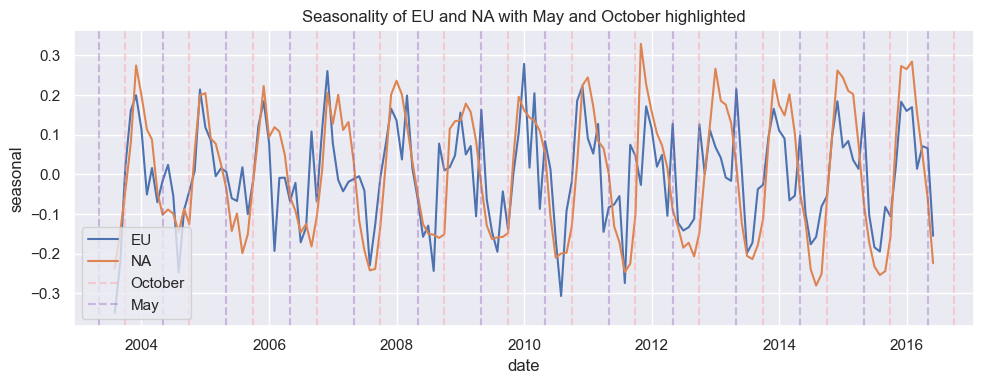

In [225]:
# To recall the initial seasonality we plot it once more here and highlight the off-peak contributions from Porters (EU only) and Dark Lagers

may_list = [pd.Timestamp(year=2003, month=5, day=1) + pd.DateOffset(years=x) for x in range(0, 14)]
oct_list = [pd.Timestamp(year=2003, month=10, day=1) + pd.DateOffset(years=x) for x in range(0, 14)]
fig, ax = plt.subplots(figsize=(10,4))
sns.lineplot(data=EU_time, x='date', y='seasonal', ax=ax, label='EU')
sns.lineplot(data=NA_time, x='date', y='seasonal', ax=ax, label='NA')
ax.set(title='Seasonality of EU and NA with May and October highlighted')
for oct in oct_list:
    if oct == oct_list[0]:
        ax.axvline(x=oct, color=max_df_NA.query("style =='Dark Lagers'").color.iloc[0], linestyle='--', alpha=0.4, label='October')
    else:
        ax.axvline(x=oct, color=max_df_EU.query("style =='Dark Lagers'").color.iloc[0], linestyle='--', alpha=0.4)
for may in may_list:
    if may == may_list[0]:
        ax.axvline(x=may, color=max_df_NA.query("style =='Porters'").color.iloc[0], linestyle='--', alpha=0.4, label='May')
    else:
        ax.axvline(x=may, color=max_df_EU.query("style =='Porters'").color.iloc[0], linestyle='--', alpha=0.4)

plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

## In this next part we consider the trend of beer styles from 2003-2016:
- We infer If the Trends between EU and NA are significantly different
- We infer whose style contributions are significant for determining the Trend using probably linear-mixed effects model

In [230]:
# create trend_dfs for EU and NA 

def Trend_df(df_dict):
    df_trend = pd.DataFrame(list(df_dict_EU.values())[0].date)
    for key, df in df_dict.items():
            df_trend[key[6:]] = df.trend
    return df_trend

trend_EU = Trend_df(df_dict_EU)
trend_NA = Trend_df(df_dict_NA)

# add the total trend 
trend_EU['EU_tot'] = EU_time.trend
trend_NA['NA_tot'] = NA_time.trend

In [231]:
# test significance of EU and NA trend time series

df_tot = abv_by_month(df_time)
df_tot_res = sm.tsa.seasonal_decompose(df_tot['abv'])
df_tot = res_to_df(df_tot_res)
df_tot

,date,abv,trend,seasonal
6,2003-08-01,5.824676,6.101571,-0.276895
7,2003-09-01,5.952212,6.111575,-0.159363
8,2003-10-01,6.083469,6.119091,-0.035622
9,2003-11-01,6.226658,6.124641,0.102017
10,2003-12-01,6.414270,6.133385,0.280885
...,...,...,...,...
156,2016-02-01,7.298905,7.015967,0.282938
157,2016-03-01,7.128052,7.008273,0.119779
158,2016-04-01,7.055856,7.004737,0.051119
159,2016-05-01,6.973576,7.003554,-0.029978


To recall the initial Trend we observed:
- The Trendline seems not too far off of a linear increase, even though we face a sort of plateau effect, we aim to model a linear fit to our data with time as covariate

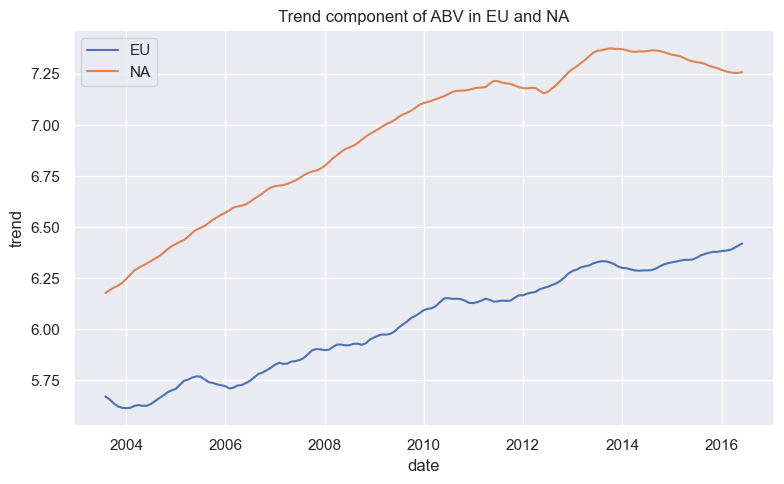

In [234]:
fig, ax = plt.subplots(figsize=(8,5))

sns.lineplot(data=EU_time, x='date', y='trend', ax=ax, label='EU')
sns.lineplot(data=NA_time, x='date', y='trend', ax=ax, label='NA')
ax.set(title='Trend component of ABV in EU and NA')

plt.legend()
plt.tight_layout()
plt.show()

In [241]:
# Using these df's for trend
display(EU_tot)

,abv
date,
2003-02-01,5.660469
2003-03-01,5.868799
2003-04-01,5.805387
2003-05-01,5.727763
2003-06-01,5.682709
...,...
2016-08-01,6.148618
2016-09-01,6.375461
2016-10-01,6.392354


In [300]:
from statsmodels import api as sm
from statsmodels.iolib.summary2 import summary_col

# create copys and reset date index
EU_trend = EU_tot.copy()
NA_trend = NA_tot.copy()

EU_trend.reset_index(inplace=True)
NA_trend.reset_index(inplace=True)

# Use count of months since the first data point that we consider for the time series
reference_date = pd.Timestamp('2003-02-01')
EU_trend['months'] = (EU_trend['date'] - reference_date) / np.timedelta64(1, 'M') # convert to months, not always integer due to dependence on day 
NA_trend['months'] = (NA_trend['date'] - reference_date) / np.timedelta64(1, 'M')


# Linear regression for EU and NA based on time
X_EU = sm.add_constant(EU_trend['months'])
X_NA = sm.add_constant(NA_trend['months'])
y_EU = EU_trend['abv']
y_NA = NA_trend['abv']

model_EU = sm.OLS(y_EU, X_EU)
model_NA = sm.OLS(y_NA, X_NA)

results_EU = model_EU.fit()
results_NA = model_NA.fit()

offset_initial = results_NA.params.const - results_EU.params.const
offset_recent = results_NA.params.const + (results_NA.params.months * 165) - results_EU.params.const + (results_EU.params.months * 165)

print(summary_col([results_EU, results_NA], stars=True, float_format='%0.4f', model_names=['EU', 'NA']))
print('----------------------------------')
print(f'Duration over {int(max(EU_trend["months"]))} months')
print(f'initial offset ({reference_date}) is {offset_initial:.2f}')
print(f'predicted offset after 165 months (13 years and 9 months) is {offset_recent:.2f}')
print(f'actual offset after 165 months (13 years and 9 months) is {NA_trend["abv"].iloc[-1] - EU_trend["abv"].iloc[-1]:.2f}')




                   EU        NA   
----------------------------------
const          5.5918*** 6.3136***
               (0.0204)  (0.0321) 
months         0.0053*** 0.0075***
               (0.0002)  (0.0003) 
R-squared      0.7913    0.7530   
R-squared Adj. 0.7900    0.7515   
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
----------------------------------
Duration over 165 months
initial offset (2003-02-01 00:00:00) is 0.72
predicted offset after 165 months (13 years and 9 months) is 2.84
actual offset after 165 months (13 years and 9 months) is 0.95


### We observe the following from this:
- There is a statistically significant increasing trend in abv over the years in both regions as shown by the low p-values (p<.01)
- The linear model explains $\approx 0.75$ of the trend for NA and $\approx 0.79$, which justifies a linear approximation, although one has to be cautious that it's not a very good fit in total, it is better for Europe though, since here the increase remains more or less the same with fluctuations
- We observe an average increase of 0.09% ABV per year in Northern America and $\approx$ 0.064% in Europe based on the monthly averaged abv's. This is remarkable considering that we see a plateauing in the Northern American trend since 2014!
- The accuracy of the model becomes more clear when comparing predictions vs. actual values. The model predicts a more than 3x higher difference in abv than we actually observe. The main deviations comes from the decline in North America since 2014